# Advanced Lane Finding Project
The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Video pipeline

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

###  Loading camera calibration

See: 01 - Camera Calibration.ipynb

In [2]:
cameraCalibration = pickle.load( open('./camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

## 2. Apply a distortion correction to raw images.

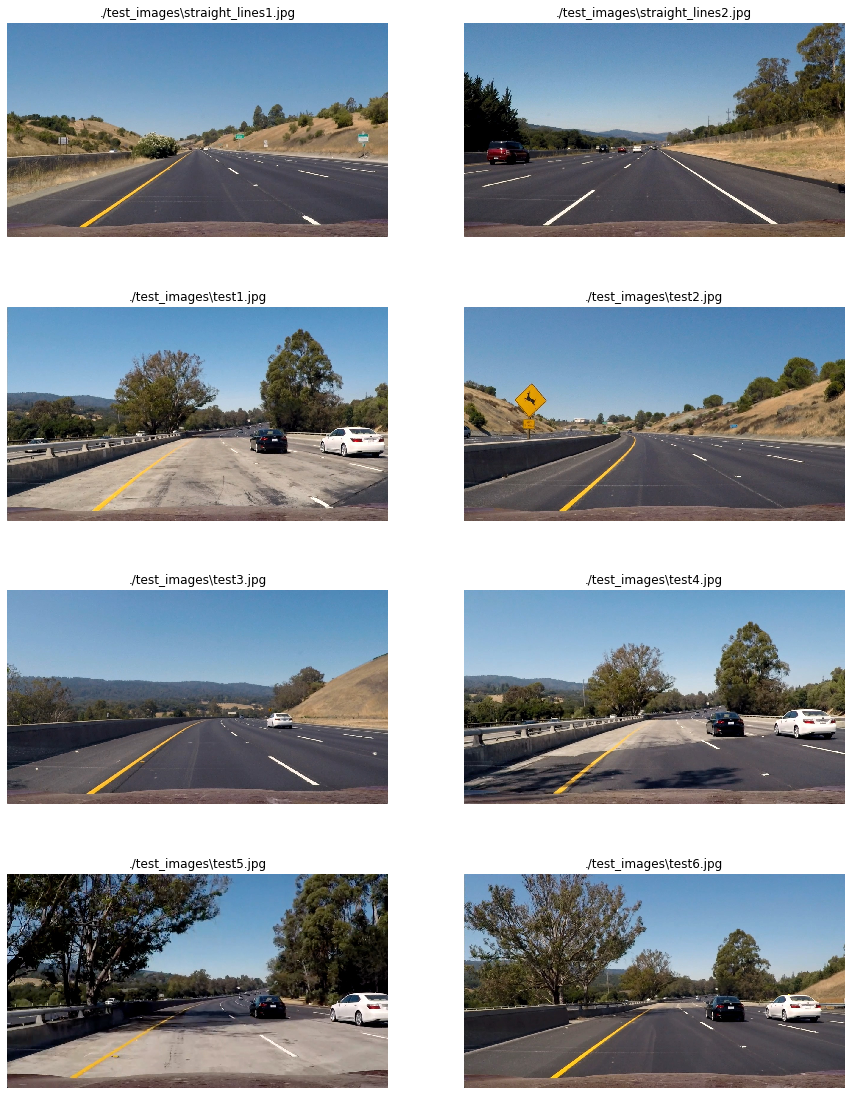

In [3]:
testImages = []
fileNames = sorted(glob.glob('./test_images/*.jpg'))
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
for ax, fileName in zip(axes.flat, fileNames):
    testImage = cv2.imread(fileName)
    testImages.append(testImage)
    testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)
    ax.imshow(testImage)
    ax.set_title(fileName)
    ax.axis('off')

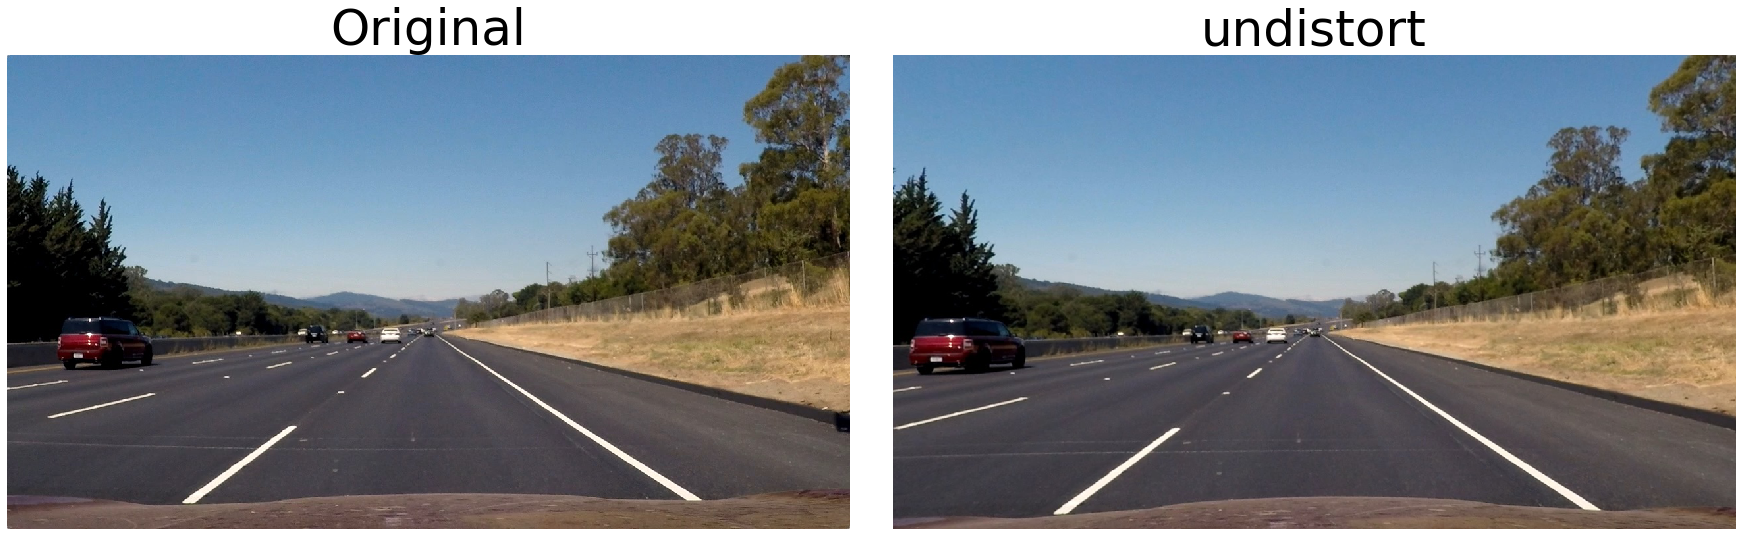

In [4]:
img = cv2.cvtColor(testImages[1],cv2.COLOR_BGR2RGB)
undist = cv2.undistort(img, mtx, dist, None, mtx)

fig, axes = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
axes[0].axis('off')
axes[0].imshow(cv2.cvtColor(testImages[1], cv2.COLOR_BGR2RGB))
axes[0].set_title('Original', fontsize=50)
axes[1].axis('off')
axes[1].imshow(undist)
axes[1].set_title('undistort', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

See: 02 - Color Transform and Gradients Threshold.ipynb

In [5]:
def undistortHLS(image, mtx=mtx, dist=dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)

hlsOriginal = undistortHLS(testImages[2])

### Color space

In [6]:
testImagesSChanne = []
for img in testImages:
    SChannel = undistortHLS(img)[:,:,2]
    testImagesSChanne.append(SChannel)

### Sobel

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if(len(img.shape)==3):    
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output    

sobelsX = []
sobelsY = []
for imgSChannel in testImagesSChanne:
    sobelsX.append(abs_sobel_thresh(imgSChannel, orient='x', thresh_min=10, thresh_max=160))
    sobelsY.append(abs_sobel_thresh(imgSChannel, orient='y', thresh_min=10, thresh_max=160))

In [8]:
def mag_thresh(img, sobelKernel=3, magThresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    # Calculate the gradient magnitude
    gradMag = np.sqrt(sobelX**2 + sobelY**2)
    # Rescale to 8 bit
    scaleFactor = np.max(gradMag)/255 
    gradMag = (gradMag/scaleFactor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binaryOutput = np.zeros_like(gradMag)
    binaryOutput[(gradMag >= magThresh[0]) & (gradMag <= magThresh[1])] = 1
    # Return the binary image
    return binaryOutput

magBinary = []
for imgSChannel in testImagesSChanne:
    magBinary.append(mag_thresh(testImage, sobelKernel=3, magThresh=(5, 160)))

In [9]:
def dir_threshold(img, sobelKernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absGradDir = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))
    binaryOutput =  np.zeros_like(absGradDir)
    binaryOutput[(absGradDir >= thresh[0]) & (absGradDir <= thresh[1])] = 1
    # Return the binary image
    return binaryOutput
   
dirBinary = []
for imgSChannel in testImagesSChanne:
    magBinary.append(dir_threshold(testImage, sobelKernel=3, thresh=(0.79, 1.20)))

### Combining

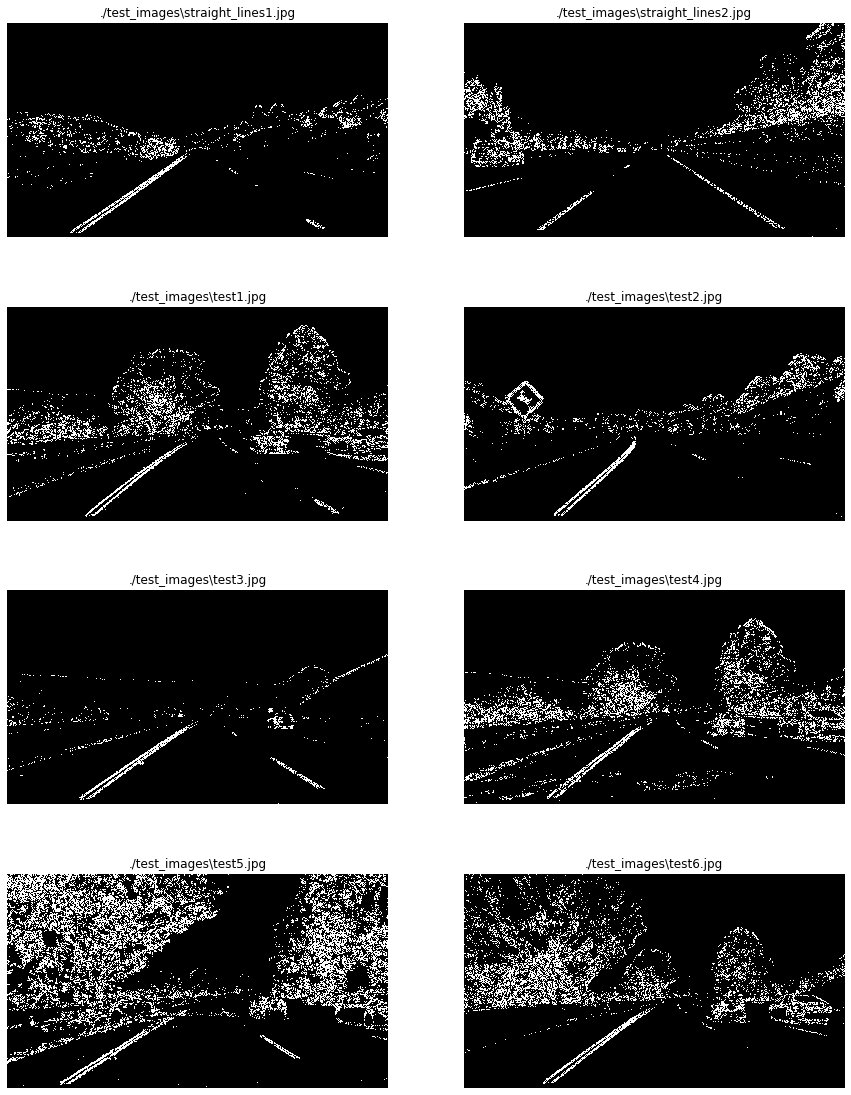

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
combineds = []
for ax, fileName, sobelX, sobelY in zip(axes.flat, fileNames, sobelsX, sobelsY):
    combined = np.zeros_like(sobelX)
    combined[((sobelX == 1) & (sobelY == 1)) | ((magBinary == 1) & (dirBinary == 1))] = 1
    combineds.append(combined)
    ax.imshow(combined, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

### Loading Perspective Transformation

See: 03 - Perspective transformation.ipynb

In [11]:
perspecResult = pickle.load( open('./perspective_transform.p', 'rb' ) )
M, Minv = map(perspecResult.get, ('M', 'Minv'))

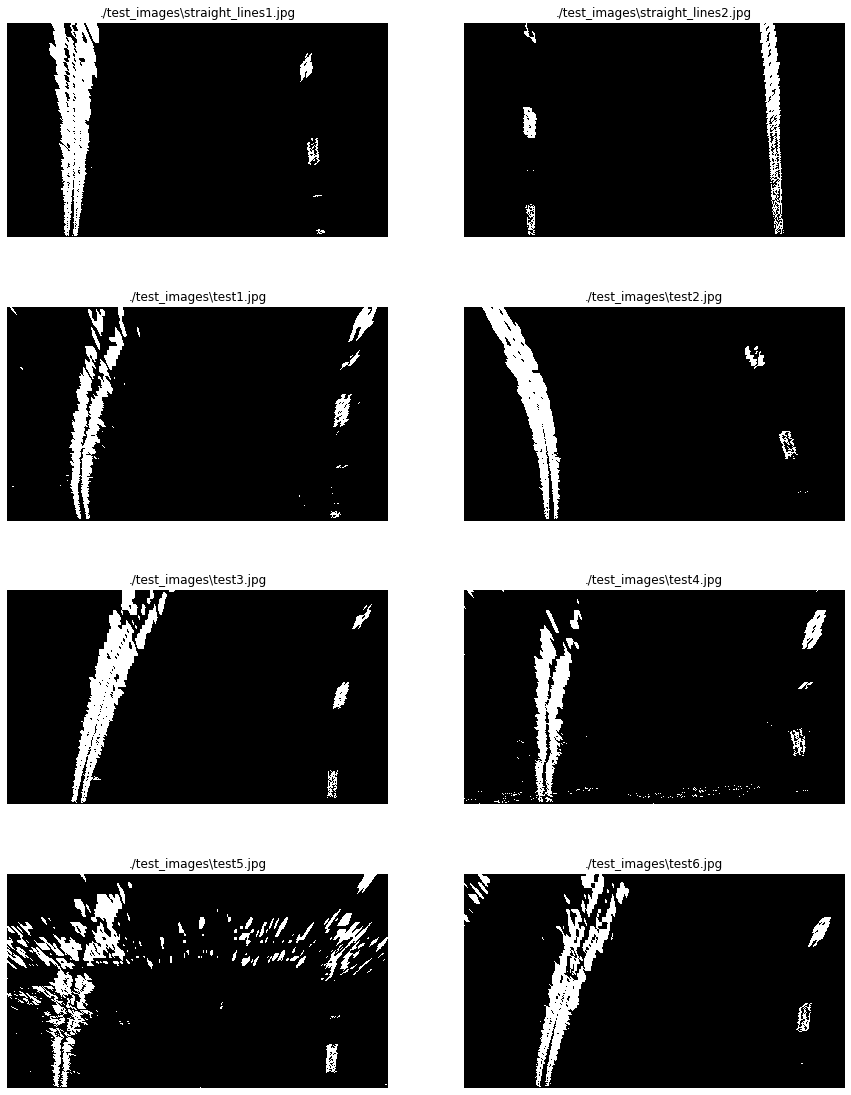

In [12]:
def perspectiveTransform(image, M=M):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
warpeds = []
for ax, fileName, combined in zip(axes.flat, fileNames, combineds):
    warped = perspectiveTransform(combined, M=M)    
    warpeds.append(warped)
    ax.imshow(warped, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## 5. Detect lane pixels and fit to find the lane boundary.

SVD did not converge in Linear Least Squares
The function failed to fit a line!


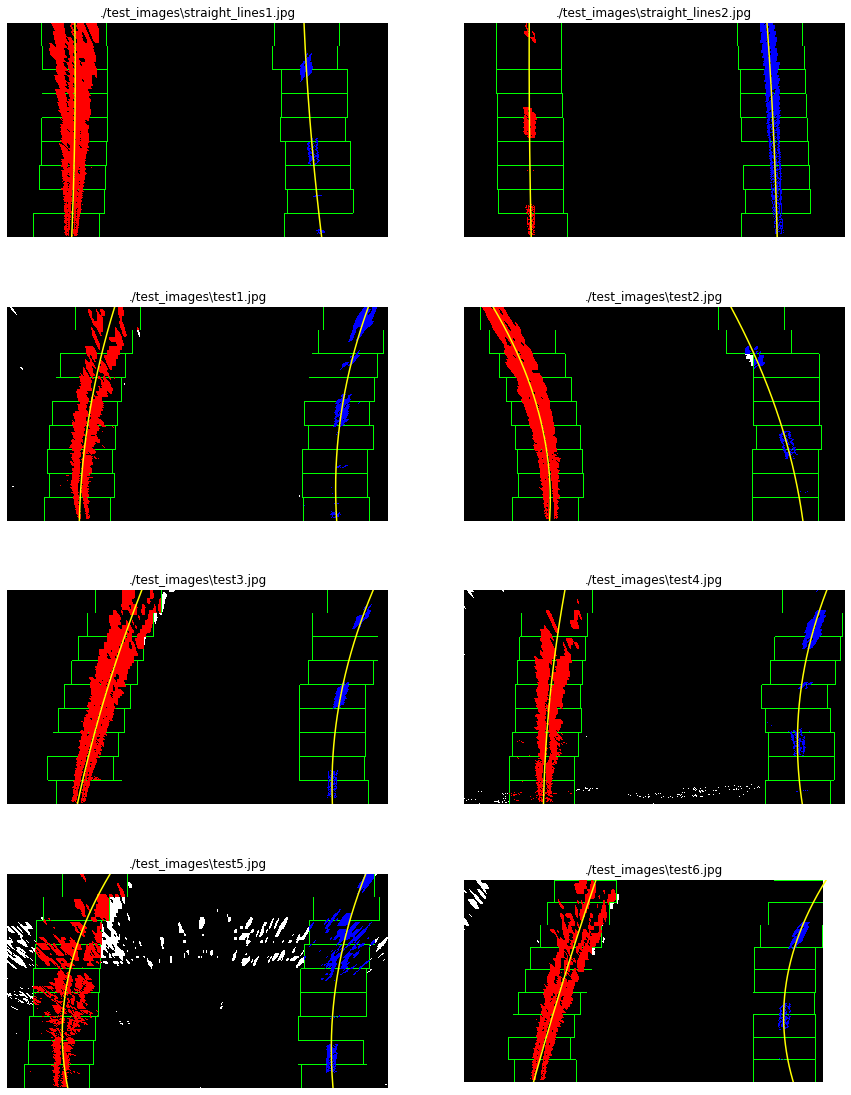

In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except BaseException as e:
        print(str(e))
        return (None, None, None, None, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_pixels(binary_warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
  
    return ( left_fitx, right_fitx, ploty, out_img, left_fit, right_fit, left_fit_m, right_fit_m )

def img_fit_polynomial(binary_warped):
    
    left_fitx, right_fitx, ploty, out_img, left_fit, right_fit, left_fit_m, right_fit_m = fit_polynomial(binary_warped)

    # show in window
    x = np.array(right_fitx)
    y = np.array(ploty)
    x = x.astype(int)
    y = y.astype(int)
    pt = np.array((x,y)).T
    cv2.polylines(out_img, [pt], isClosed=False, color=(0,255,255),thickness=2)
    x = np.array(left_fitx)
    y = np.array(ploty)
    x = x.astype(int)
    y = y.astype(int)
    pt = np.array((x,y)).T
    cv2.polylines(out_img, [pt], isClosed=False, color=(0,255,255),thickness=2)
    
    return out_img, left_fitx, right_fitx, ploty


def plt_fit_polynomial(binary_warped, ax, fileName):
    # Find our lane pixels first
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_pixels(binary_warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_fitx, right_fitx, ploty, out_img, left_fit, right_fit, left_fit_m, right_fit_m = fit_polynomial(binary_warped)

    # Plots the left and right polynomials on the lane lines
    ax.imshow(out_img)
    ax.set_title(fileName)
    ax.axis('off')    
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
   
    return (fileName, left_fit, right_fit, left_fit_m, right_fit_m )

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
imagesFit = []
for ax, fileName, warped in zip(axes.flat, fileNames, warpeds):
    imageFit = plt_fit_polynomial(warped, ax, fileName)
    imagesFit.append(imageFit)

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [14]:
def calculateCurvature(yRange, left_fit_cr):
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for imageFit in imagesFit:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imageFit
    if left_fit is not None:
        yRange = 719
        leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
        rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
        print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))       
    else:
        print('Image : {} error'.format(imagePath))

Image : ./test_images\straight_lines1.jpg, Left : 4.26 km, Right : 3.00 km
Image : ./test_images\straight_lines2.jpg, Left : 9.01 km, Right : 4.98 km
Image : ./test_images\test1.jpg, Left : 0.83 km, Right : 0.55 km
Image : ./test_images\test2.jpg, Left : 0.36 km, Right : 0.59 km
Image : ./test_images\test3.jpg, Left : 1.33 km, Right : 0.51 km
Image : ./test_images\test4.jpg, Left : 1.49 km, Right : 0.43 km
Image : ./test_images\test5.jpg, Left : 0.30 km, Right : 0.49 km
Image : ./test_images\test6.jpg, Left : 3.80 km, Right : 0.26 km


## 7. Warp the detected lane boundaries back onto the original image.

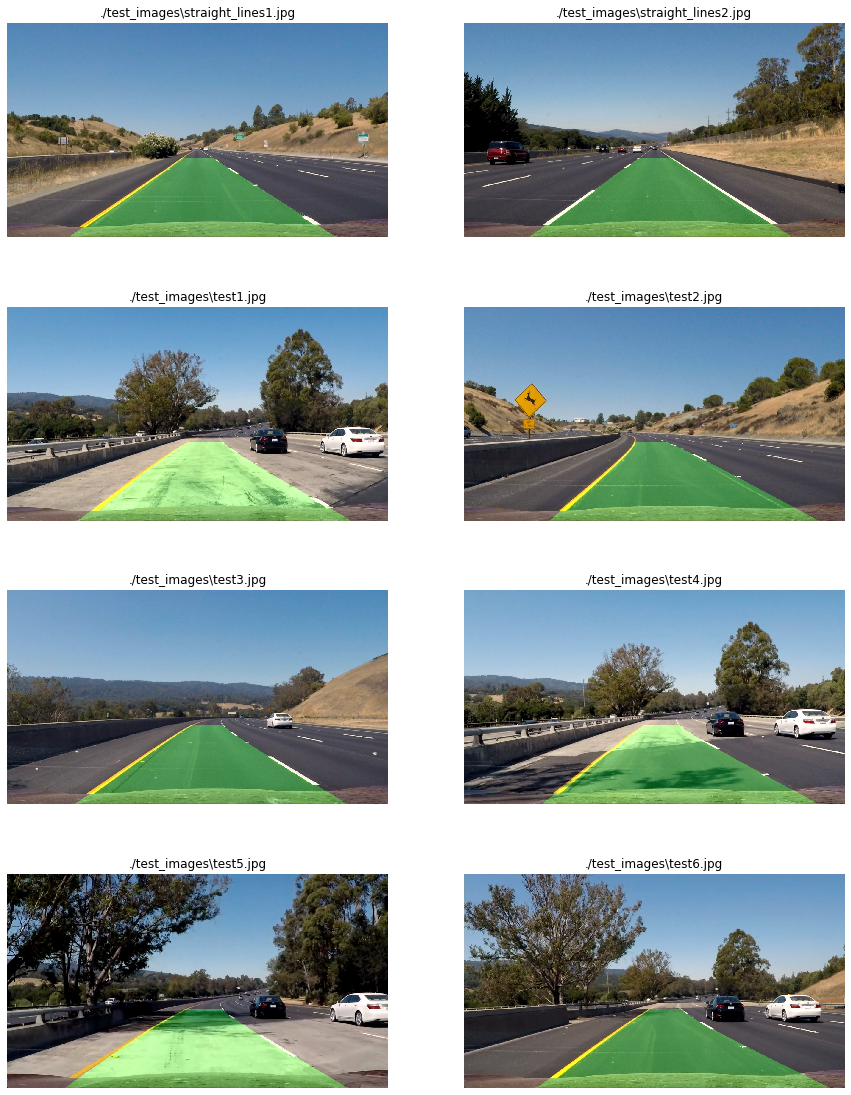

In [15]:
def drawLine(img, left_fit, right_fit):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img, transf):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_pixels(transf)
    if left_fit is None:
        return img
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
for ax, fileName, testImage, warped in zip(axes.flat, fileNames, testImages, warpeds):
    ax.imshow(drawLaneOnImage(testImage, warped))
    ax.set_title(fileName)
    ax.axis('off')

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

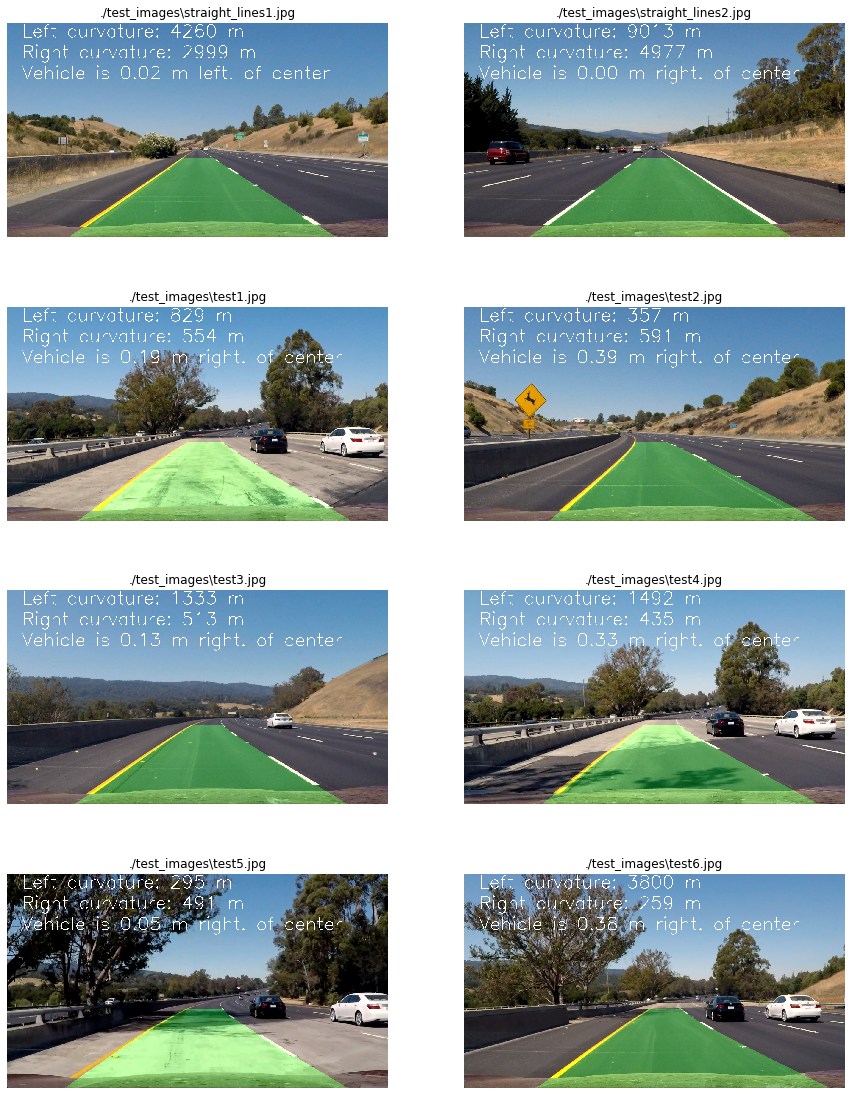

In [16]:
def estimationsLane(img, warped, fontScale=2):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_pixels(warped)
    if left_fit is None:
        return img
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right.'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left.'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

fileNames = sorted(glob.glob('./test_images/*.jpg'))
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
for ax, fileName, warped in zip(axes.flat, fileNames, warpeds):
    img = cv2.imread(fileName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(estimationsLane(img, warped))
    ax.set_title(fileName)
    ax.axis('off')

## 9. Video pipeline

In [18]:
from moviepy.editor import VideoFileClip
import cv2
%matplotlib

debug = False

frame = 1
frames_errors = [1040, 1042]
distances_limits = []
if debug:
    distances_limits = [[10000,0],[10000,0],[10000,0]]
else:
    distances_limits = pickle.load( open('./distances_limits.p','rb' ) )
    if len(distances_limits) == 0:
        distances_limits = [[0,0],[0,0],[0,0]]

class LastLane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None
    def attrib(self):
        return self.left_fit,  self.right_fit, self.left_fit_m, self.right_fit_m, self.leftCurvature, self.rightCurvature
        
def binary2Color(binary_img):
    bin_img = binary_img.copy()
    r = np.array(bin_img, dtype='uint8').T
    g = np.array(bin_img, dtype='uint8').T
    b = np.array(bin_img, dtype='uint8').T
    color = np.array((b,g,r), dtype='uint8').T
    return color

def imagePipeline(img):
    SChannel = undistortHLS(img)[:,:,2]
    sobelX = abs_sobel_thresh(SChannel, orient='x', thresh_min=10, thresh_max=160)
    sobelY = abs_sobel_thresh(SChannel, orient='y', thresh_min=10, thresh_max=160)
    
    magBinnary = mag_thresh(img, sobelKernel=3, magThresh=(5, 160))
    dirBinary = dir_threshold(img, sobelKernel=3, thresh=(0.79, 1.20))

    combined = np.zeros_like(sobelX)

    combined[((sobelX == 1) & (sobelY == 1)) | ((magBinary == 1) & (dirBinary == 1))] = 1
    
    warped = perspectiveTransform(combined, M=M) 
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_pixels(warped)
    if left_fit is not None:
        # Calculate curvature
        leftCurvature = calculateCurvature(yRange, left_fit_m) 
        rightCurvature = calculateCurvature(yRange, right_fit_m)
    
        # Calculate vehicle center
        xMax = img.shape[1]*xm_per_pix
        yMax = img.shape[0]*ym_per_pix
        vehicleCenter = xMax / 2
        lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
        lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
        lineMiddle = lineLeft + (lineRight - lineLeft)/2
        diffFromVehicle = lineMiddle - vehicleCenter
    else:
        leftCurvature = 0
        rightCurvature = 0
        diffFromVehicle = 0

    sobelX[sobelX > 0] = 255
    sobelY[sobelY > 0] = 255
    magBinnary[magBinnary > 0] = 255
    dirBinary[dirBinary > 0] = 255
    combined[combined > 0] = 255
    warped[warped > 0] = 255
    
    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((960, 1706, 3), np.uint8)

    # Copy both images into the composed image.
    vis[  0:240,     0:426]   = cv2.resize(cv2.cvtColor(SChannel, cv2.COLOR_GRAY2BGR),(426, 240), interpolation = cv2.INTER_AREA)
    vis[  0:240,   426:426*2] = cv2.resize(binary2Color(sobelX),(426, 240), interpolation = cv2.INTER_AREA)
    vis[  0:240, 426*2:426*3] = cv2.resize(binary2Color(sobelY),(426, 240), interpolation = cv2.INTER_AREA)
    vis[  0:240, 426*3:426*4] = cv2.resize(binary2Color(magBinnary),(426, 240), interpolation = cv2.INTER_AREA)
    vis[240:480,  1280:1706]  = cv2.resize(binary2Color(dirBinary),(426, 240), interpolation = cv2.INTER_AREA)
    vis[480:720,  1280:1706]  = cv2.resize(binary2Color(combined),(426, 240), interpolation = cv2.INTER_AREA)
    out_img, left_fitx, right_fitx, ploty = img_fit_polynomial(warped)
    vis[720:960,  1280:1706]  = cv2.resize(out_img,(426, 240), interpolation = cv2.INTER_AREA)

    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 255, 255)
    fontScale = 0.4
    cv2.putText(vis, 'S Channel', (5, 10), font, fontScale, fontColor, 1)
    cv2.putText(vis, 'Sobel X', (426+5, 10), font, fontScale, fontColor, 1)
    cv2.putText(vis, 'Sobel Y', ((426*2)+5, 10), font, fontScale, fontColor, 1)
    cv2.putText(vis, 'Magnitude', ((426*3)+5, 10), font, fontScale, fontColor, 1)
    cv2.putText(vis, 'Direction', ((426*3)+5, 240+10), font, fontScale, fontColor, 1)
    cv2.putText(vis, 'Combined', ((426*3)+5, 480+10), font, fontScale, fontColor, 1)
    cv2.putText(vis, 'fit Polynomial', ((426*3)+5, 720+10), font, fontScale, fontColor, 1)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, vis, left_fitx, right_fitx, ploty)

def drawLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, debug = False):

    if left_fit is None:
        return img
    
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    cv2.putText(output, 'Frame: {}'.format(frame), (50, 260), font, 1, fontColor, 2)
    return output
 
def lane_check(left_fitx, right_fitx):
    ok = True
    # checking bottom distance 
    distance_bottom = right_fitx[len(left_fitx)-1] - left_fitx[len(right_fitx)-1]
    # checking middle distance 
    distance_middle = right_fitx[len(left_fitx)//2] - left_fitx[len(right_fitx)//2]
    # Checking top distance
    distance_top = right_fitx[0] - left_fitx[0]
        
    if ((distance_top < distances_limits[0][0]) or (distance_top > distances_limits[0][1])): 
        ok = False 
    if ((distance_middle < distances_limits[1][0]) or (distance_middle > distances_limits[1][1])): 
        ok = False
    if ((distance_bottom < distances_limits[2][0]) or (distance_bottom > distances_limits[2][1])): 
        ok = False

    return ok, distance_bottom, distance_middle, distance_top
    
def videoPipeline(inputVideo, outputVideo, debug = False):
    myclip = VideoFileClip(inputVideo)
    
    leftLastLane = LastLane()
    rightLastLane = LastLane()
    
    def processImage(img):
        global frame, distances_limits, frames_errors
        
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, vis, left_fitx, right_fitx, ploty = imagePipeline(img)
       
        lane_ok, distance_bottom, distance_middle, distance_top = lane_check(left_fitx, right_fitx)
        if debug:
            lane_ok = True
        
        if not(frame in frames_errors) and debug:
            distances_limits = [[min(distances_limits[0][0],distance_top), max(distances_limits[0][1],distance_top)],
                                [min(distances_limits[1][0],distance_middle), max(distances_limits[1][1],distance_middle)],
                                [min(distances_limits[2][0],distance_bottom), max(distances_limits[2][1],distance_bottom)]]
        
        if leftCurvature > 10000 or not lane_ok:
            left_fit = leftLastLane.left_fit
            left_fit_m = leftLastLane.left_fit_m
            leftCurvature = leftLastLane.leftCurvature
        else:
            leftLastLane.left_fit = left_fit
            leftLastLane.left_fit_m = left_fit_m
            leftLastLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000 or not lane_ok:
            right_fit = rightLastLane.right_fit
            right_fit_m = rightLastLane.right_fit_m
            rightCurvature = rightLastLane.rightCurvature
        else:
            rightLastLane.right_fit = right_fit
            rightLastLane.right_fit_m = right_fit_m
            rightLastLane.rightCurvature = rightCurvature

        out_drawLanes = drawLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, debug)        

        vis[240:960, 0:1280] =  cv2.cvtColor(out_drawLanes, cv2.COLOR_RGB2BGR)

        if frame in frames_errors:
            cv2.imwrite("output_images/frame" + ("Error" if debug else "Ok") + str(frame) + ".jpg", vis) 
        
        out_image = vis if debug else cv2.cvtColor(out_drawLanes, cv2.COLOR_RGB2BGR)
        cv2.imshow('Output Video', out_image)
        k = cv2.waitKey(1)
        if k == 112:  # [p]ause
            cv2.waitKey(0)
            
        frame += 1    
            
        return cv2.resize(cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR),(1280, 720), interpolation = cv2.INTER_AREA)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
file = 'project_video'
videoPipeline(file + '.mp4', 'output_images/' + file + '_debug.mp4' if debug else 'output_images/' + file + '.mp4', debug)
cv2.destroyAllWindows()
if debug:
    print(distances_limits)
    pickle.dump( distances_limits, open('./distances_limits.p', 'wb'))
    print('./distances_limits.p saved!')



Using matplotlib backend: Qt5Agg


t:   0%|                                    | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
